# Esophagitis Severity Classification (2 Classes)

### Download and extract the Dataset.

In [1]:
!mkdir kvasir
!wget --no-check-certificate 'https://pern-my.sharepoint.com/:u:/g/personal/m21f0034ai010_fecid_paf-iast_edu_pk/ETUX9oiTyy1Dobrv87loEoQB8DTIkZpeCpZdhyGgW9a5MQ?e=9GwedY&download=1' -O esophagitis-severity.zip
!unzip /content/esophagitis-severity.zip
!mv /content/content/kvasir/labeled-images/upper-gi-tract/pathological-findings /content/kvasir
!rm -r /content/content

--2024-01-08 16:01:56--  https://pern-my.sharepoint.com/:u:/g/personal/m21f0034ai010_fecid_paf-iast_edu_pk/ETUX9oiTyy1Dobrv87loEoQB8DTIkZpeCpZdhyGgW9a5MQ?e=9GwedY&download=1
Resolving pern-my.sharepoint.com (pern-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to pern-my.sharepoint.com (pern-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/m21f0034ai010_fecid_paf-iast_edu_pk/Documents/MS%20AI/4-Spring%202023/Data/esophagitis-severity.zip?ga=1 [following]
--2024-01-08 16:01:57--  https://pern-my.sharepoint.com/personal/m21f0034ai010_fecid_paf-iast_edu_pk/Documents/MS%20AI/4-Spring%202023/Data/esophagitis-severity.zip?ga=1
Reusing existing connection to pern-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 435304862 (415M) [application/x-zip-compressed]
Saving to: ‘esophagitis-severity.zip’

esophagitis-severit 100%[===================>] 415.14M  57.1

## Verify data directories

In [2]:
!ls /content/kvasir/pathological-findings

esophagitis-a  esophagitis-b-d


In [3]:
#import libraries

import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D

In [4]:
#dataset path

dataset_directory = "/content/kvasir/pathological-findings"

## Creating Random Train and Validation Splits

In [5]:
# train-test-splits
training_data = tf.keras.preprocessing.image_dataset_from_directory(dataset_directory,
                                                               labels="inferred",
                                                               image_size=(224, 224),
                                                               batch_size=16,
                                                               subset="training",
                                                               validation_split=0.222222222,
                                                               seed=123
                                                               )

validation_data = tf.keras.preprocessing.image_dataset_from_directory(dataset_directory,
                                                              labels="inferred",
                                                              image_size=(224, 224),
                                                              batch_size=16,
                                                              subset="validation",
                                                              validation_split=0.222222222,
                                                              seed=123
                                                              )

Found 597 files belonging to 2 classes.
Using 465 files for training.
Found 597 files belonging to 2 classes.
Using 132 files for validation.


In [6]:
#classes labels

print(len(training_data.class_names), "Classes are:", training_data.class_names)

2 Classes are: ['esophagitis-a', 'esophagitis-b-d']


## Visualization

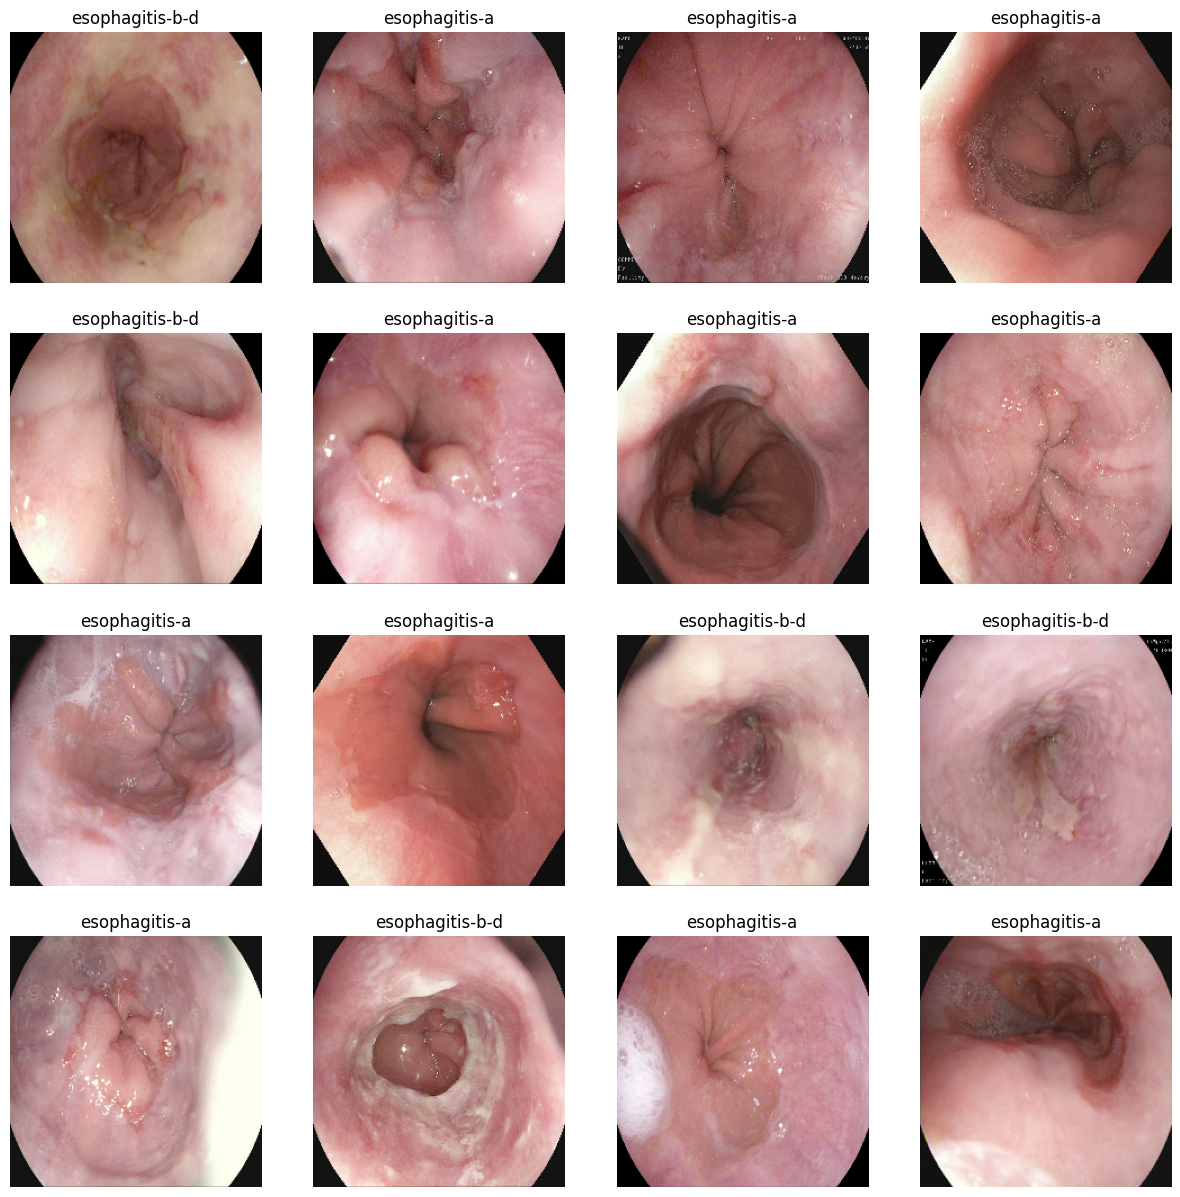

In [7]:
#image plot

plt.figure(figsize=(15, 15))
for images, labels in training_data.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(training_data.class_names[labels[i]])
    plt.axis('off')

In [8]:
import os
from sklearn.model_selection import train_test_split

# Get the list of class names
class_names = os.listdir(dataset_directory)
num_classes = len(class_names)

# Initialize dictionaries to store the counts for each class
training_counts = {class_name: 0 for class_name in class_names}
validation_counts = {class_name: 0 for class_name in class_names}

# Iterate over the dataset directory to count the images for each class
for class_name in class_names:
    class_directory = os.path.join(dataset_directory, class_name)
    file_names = os.listdir(class_directory)
    num_files = len(file_names)

    # Split the file names into training and validation sets
    train_files, validation_files = train_test_split(file_names, test_size=0.2, random_state=123)

    # Update the counts for training and validation sets
    training_counts[class_name] = len(train_files)
    validation_counts[class_name] = len(validation_files)

# Print the number of images for each class in the training set
print("Training Set:")
for class_name, count in training_counts.items():
    print(f"Class: {class_name}, Count: {count}")

# Print the number of images for each class in the validation set
print("Validation Set:")
for class_name, count in validation_counts.items():
    print(f"Class: {class_name}, Count: {count}")

Training Set:
Class: esophagitis-a, Count: 290
Class: esophagitis-b-d, Count: 187
Validation Set:
Class: esophagitis-a, Count: 73
Class: esophagitis-b-d, Count: 47


In [9]:
training_data.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Model Architecture and Training

In [10]:
num_classes = len(training_data.class_names)

inputs = keras.Input(shape=(224, 224, 3))

x = keras.applications.vgg16.preprocess_input(inputs)

# Load pre-trained Xception model
base_model = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
base_model.trainable = False

# Pass inputs through base model
x = base_model(x)

# Add pooling layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add dropout layer
x = keras.layers.Dropout(0.2)(x)

# Add dense output layer with softmax activation
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Define the model
model = keras.Model(inputs, outputs)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

epochs = 50

history = model.fit(training_data,
                    validation_data = validation_data,
                    epochs = epochs)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
30/30 [==============================] - 16s 275ms/step - loss: 2.4838 - accuracy: 0.5075 - val_loss: 1.3930 - val_accuracy: 0.5833
Epoch 2/50
30/30 [==============================] - 7s 184ms/step - loss: 1.7081 - accuracy: 0.5806 - val_loss: 1.1508 - val_accuracy: 0.6591
Epoch 3/50
30/30 [==============================] - 7s 181ms/step - loss: 1.1322 - accuracy: 0.7054 - val_loss: 1.0417 - val_accuracy: 0.6970
Epoch 4/50
30/30 [==============================] - 8s 233ms/step - loss: 1.1153 - accuracy: 0.6817 - val_loss: 0.9468 - val_accuracy: 0.7197
Epoch 5/50
30/30 [==============================] - 8s 232ms/step - loss: 0.9805 - accuracy: 0.6968 - val_loss: 0.8649 - val_accuracy: 0.7348
Epoch 6/50
30/30 [==============================] - 7s 183ms/step - loss: 0.8578 - accuracy: 0.6925 - val_loss: 0.7974 - val_accuracy: 0.6970
Epoch 7/50
30/30 [==============================] - 8s 211ms/step - loss: 0.7695 -

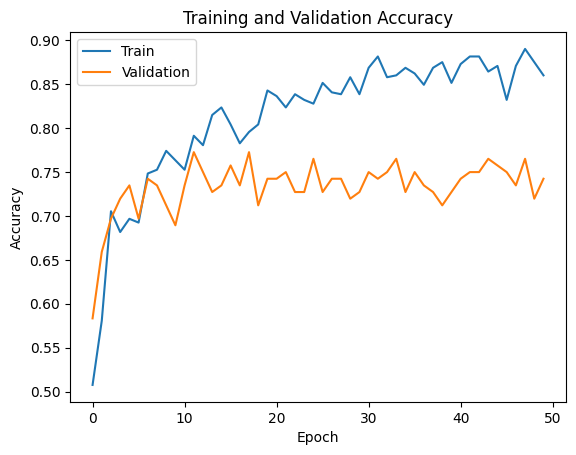

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
max_train_accuracy = max(history.history['accuracy'])
print('Maximum Training Accuracy:', max_train_accuracy)
max_val_accuracy = max(history.history['val_accuracy'])
print('Maximum Validation Accuracy:', max_val_accuracy)

Maximum Training Accuracy: 0.8903225660324097
Maximum Validation Accuracy: 0.7727272510528564


## Model Finetuning

In [13]:
#Fine tuning the entire model

#unfreeze the top layers
base_model.tainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=.00001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

history_ft = model.fit(training_data,
                    validation_data = validation_data,
                    epochs = 20,
                    callbacks=[checkpoint])

Epoch 1/20
30/30 [==============================] - 10s 239ms/step - loss: 0.2429 - accuracy: 0.9075 - val_loss: 0.6296 - val_accuracy: 0.7424
Epoch 2/20
30/30 [==============================] - 7s 198ms/step - loss: 0.2666 - accuracy: 0.8968 - val_loss: 0.6319 - val_accuracy: 0.7500
Epoch 3/20
30/30 [==============================] - 10s 262ms/step - loss: 0.2426 - accuracy: 0.8925 - val_loss: 0.6300 - val_accuracy: 0.7424
Epoch 4/20
30/30 [==============================] - 7s 188ms/step - loss: 0.2438 - accuracy: 0.9011 - val_loss: 0.6268 - val_accuracy: 0.7424
Epoch 5/20
30/30 [==============================] - 7s 209ms/step - loss: 0.2772 - accuracy: 0.8817 - val_loss: 0.6275 - val_accuracy: 0.7424
Epoch 6/20
30/30 [==============================] - 7s 199ms/step - loss: 0.2507 - accuracy: 0.8946 - val_loss: 0.6281 - val_accuracy: 0.7424
Epoch 7/20
30/30 [==============================] - 9s 253ms/step - loss: 0.2393 - accuracy: 0.8882 - val_loss: 0.6275 - val_accuracy: 0.7424
Epoc

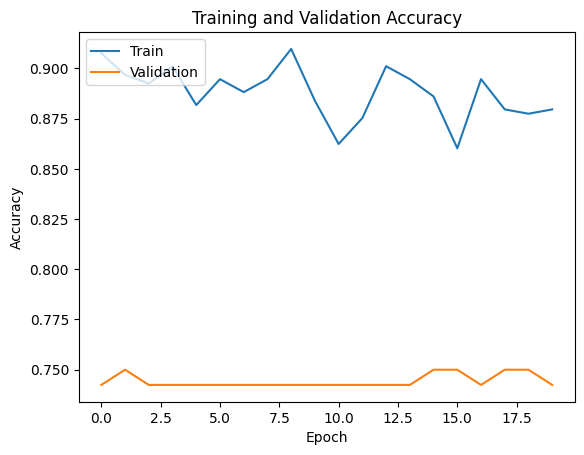

In [14]:
import matplotlib.pyplot as plt
# Plot training and validation metrics
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing for Unseen Data.

In [15]:
# Load the model with the highest validation accuracy
best_model = model.load_weights('best_model.keras')

In [16]:
!mkdir kvasir-valid
!wget --no-check-certificate 'https://pern-my.sharepoint.com/:u:/g/personal/m21f0034ai010_fecid_paf-iast_edu_pk/EeQQ4EsiCa9DqXpKH04T_lgB29wtQVSBnPvABYtFaVL8hw?e=YUkJIh&download=1' -O eshphagitis-severity-validation.zip
!unzip /content/eshphagitis-severity-validation.zip
!mv /content/content/eshphagitis-severity-validation /content/kvasir-valid
!rm -r /content/content

--2024-01-08 16:13:01--  https://pern-my.sharepoint.com/:u:/g/personal/m21f0034ai010_fecid_paf-iast_edu_pk/EeQQ4EsiCa9DqXpKH04T_lgB29wtQVSBnPvABYtFaVL8hw?e=YUkJIh&download=1
Resolving pern-my.sharepoint.com (pern-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to pern-my.sharepoint.com (pern-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/m21f0034ai010_fecid_paf-iast_edu_pk/Documents/MS%20AI/4-Spring%202023/Data/eshphagitis-severity-validation.zip?ga=1 [following]
--2024-01-08 16:13:01--  https://pern-my.sharepoint.com/personal/m21f0034ai010_fecid_paf-iast_edu_pk/Documents/MS%20AI/4-Spring%202023/Data/eshphagitis-severity-validation.zip?ga=1
Reusing existing connection to pern-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 47456989 (45M) [application/x-zip-compressed]
Saving to: ‘eshphagitis-severity-validation.zip’

eshphagitis-severit 100%[====

In [17]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/kvasir-valid/eshphagitis-severity-validation',
    image_size=(224, 224),
    batch_size=16,
    shuffle=False,
    )

Found 66 files belonging to 2 classes.


In [18]:
# Extract true labels from the directory structure
true_labels = []
for images, labels in validation_dataset:
    true_labels.extend(labels.numpy())

# Convert to numpy array
true_labels = np.array(true_labels)

# Make predictions using the model on the validation dataset
predictions = model.predict(validation_dataset)

# Ensure the number of samples matches
num_samples_predictions = len(predictions)
num_samples_true_labels = len(true_labels)

if num_samples_predictions != num_samples_true_labels:
    print(f"Error: Mismatch in the number of samples - Predictions: {num_samples_predictions}, True Labels: {num_samples_true_labels}")
else:
    # Evaluate the model's performance
    from sklearn.metrics import accuracy_score, classification_report, f1_score

    predicted_labels = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"\nAccuracy: {accuracy}")

    f1 = f1_score(true_labels, predicted_labels)
    print(f"\F1 Score: {f1}")

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

5/5 [==============================] - 2s 432ms/step

Accuracy: 0.6666666666666666
\F1 Score: 0.5217391304347826

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.74        40
           1       0.60      0.46      0.52        26

    accuracy                           0.67        66
   macro avg       0.65      0.63      0.63        66
weighted avg       0.66      0.67      0.66        66



In [19]:
max_train_accuracy = max(history_ft.history['accuracy'])
print('Maximum Training Accuracy:', max_train_accuracy)
max_val_accuracy = max(history_ft.history['val_accuracy'])
print('Maximum Validation Accuracy:', max_val_accuracy)

Maximum Training Accuracy: 0.9096774458885193
Maximum Validation Accuracy: 0.75


In [20]:
print("Training accuracy list:", history.history['accuracy'])
print("Validation accuracy list:", history.history['val_accuracy'])

print("Training accuracy list (finetuned):", history_ft.history['accuracy'])
print("Validation accuracy list (finetuned):", history_ft.history['val_accuracy'])

Training accuracy list: [0.5075268745422363, 0.5806451439857483, 0.7053763270378113, 0.6817204356193542, 0.6967741847038269, 0.6924731135368347, 0.7483870983123779, 0.7526881694793701, 0.774193525314331, 0.7634408473968506, 0.7526881694793701, 0.7913978695869446, 0.7806451320648193, 0.8150537610054016, 0.823655903339386, 0.8043010830879211, 0.7827957272529602, 0.7956989407539368, 0.8043010830879211, 0.8430107235908508, 0.8365591168403625, 0.823655903339386, 0.8387096524238586, 0.8322580456733704, 0.8279569745063782, 0.85161292552948, 0.8408601880073547, 0.8387096524238586, 0.8580645322799683, 0.8387096524238586, 0.8688172101974487, 0.8817204236984253, 0.8580645322799683, 0.8602150678634644, 0.8688172101974487, 0.8623656034469604, 0.8494623899459839, 0.8688172101974487, 0.875268816947937, 0.85161292552948, 0.8731182813644409, 0.8817204236984253, 0.8817204236984253, 0.8645161390304565, 0.8709677457809448, 0.8322580456733704, 0.8709677457809448, 0.8903225660324097, 0.875268816947937, 0.86